In [23]:
import numpy as np
import matplotlib.pyplot as plt
from bidding_environment import *
from pricing_environment import *
from ts_learner import *
from gts_learner import *
from gpts_learner import *
import pulp

n_arms = 10
T = 40

min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_arms)
sigma = 10

regrets_per_subcampaign = []
rewards_per_subcampaign = []

env = None
gpts_learner = None

for subcampaing in [3]:
    env = BiddingEnvironment(bids=bids, sigma=sigma, subcampaing=subcampaing)
    gpts_learner = GPTS_Learner(n_arms=n_arms, arms=bids)
    for t in range(T):
        pulled_arm = gpts_learner.pull_arm()
        reward = env.round(pulled_arm)
        gpts_learner.update(pulled_arm, reward)

    rewards_per_subcampaign.append(gpts_learner.means - gpts_learner.sigmas)
    opt = np.max(env.means) #todo:check this
    regrets_per_subcampaign.append(opt - gpts_learner.collected_rewards)

print(rewards_per_subcampaign)


[array([40.19666159, 46.03653275, 51.85911648, 57.21454282, 60.94488411,
       61.57985282, 57.57656342, 48.47879145, 36.20992405, 23.8590742 ])]


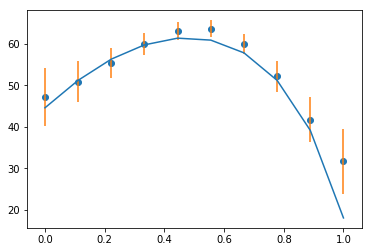

In [24]:
plt.plot(env.bids, env.means)
plt.scatter(env.bids, gpts_learner.means)
plt.errorbar(
    env.bids,
    gpts_learner.means,
    xerr=0,
    yerr=gpts_learner.sigmas,
    linestyle='',
)
plt.show()

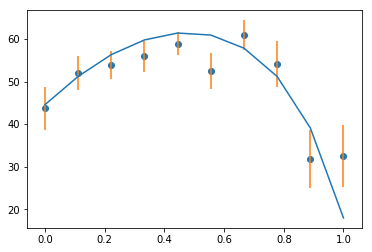

In [20]:
plt.plot(env.bids, env.means)
plt.scatter(env.bids, gpts_learner.means)
plt.errorbar(
    env.bids,
    gpts_learner.means,
    xerr=0,
    yerr=gpts_learner.sigmas,
    linestyle='',
)
plt.show()

In [ ]:
# print(rewards_per_subcampaign)
def get_reward(i, sub):
    return rewards_per_subcampaign[sub - 1][i]

def get_bid(i):
    return bids[i]

sub_1_choice = pulp.LpVariable.dicts('sub_1_choice', [i for i in range(n_arms)],
                            lowBound = 0,
                            upBound = 1,
                            cat = pulp.LpInteger)

sub_2_choice = pulp.LpVariable.dicts('sub_2_choice', [i for i in range(n_arms)],
                            lowBound = 0,
                            upBound = 1,
                            cat = pulp.LpInteger)

sub_3_choice = pulp.LpVariable.dicts('sub_3_choice', [i for i in range(n_arms)],
                            lowBound = 0,
                            upBound = 1,
                            cat = pulp.LpInteger)

p1_model = pulp.LpProblem("P1 Model", pulp.LpMaximize)
p1_model += (
    sum([get_reward(choice, 1) * sub_1_choice[choice] for choice in range(n_arms)]) +
    sum([get_reward(choice, 2) * sub_2_choice[choice] for choice in range(n_arms)]) +
    sum([get_reward(choice, 3) * sub_3_choice[choice] for choice in range(n_arms)])
)


p1_model += sum([sub_1_choice[choice] for choice in range(n_arms)]) <= 1
p1_model += sum([sub_2_choice[choice] for choice in range(n_arms)]) <= 1
p1_model += sum([sub_3_choice[choice] for choice in range(n_arms)]) <= 1

p1_model += (
    sum([get_bid(choice) * sub_1_choice[choice] for choice in range(n_arms)]) +
    sum([get_bid(choice) * sub_2_choice[choice] for choice in range(n_arms)]) +
    sum([get_bid(choice) * sub_3_choice[choice] for choice in range(n_arms)])
) <= 1.0

p1_model.solve()

adv_rew = [[] for _ in range(3)]

for choice in range(n_arms):
    if sub_1_choice[choice].value() == 1.0:
        print(1, choice, bids[choice], get_reward(choice, 1))
        adv_rew[0] = get_reward(choice,1)
    if sub_2_choice[choice].value() == 1.0:
        print(2, choice, bids[choice], get_reward(choice, 2))
        adv_rew[1] = get_reward(choice,2)
    if sub_3_choice[choice].value() == 1.0:
        print(3, choice, bids[choice], get_reward(choice, 3))
        adv_rew[2] = get_reward(choice,3)

# plt.figure(0)
# plt.xlabel("t")
# plt.ylabel("Regret")
# plt.plot(np.cumsum(np.mean(opt-gpts_rewards_per_experiment, axis=0)), 'g')
# plt.legend(["GPTS"])
# plt.show()
'''
TROVARE L'OTTIMO
'''
n_arms = 25
prices = np.linspace(50, 100, n_arms)

env1 = PricingEnvironment(n_arms = n_arms, subcampaign = 1)
env2 = PricingEnvironment(n_arms = n_arms, subcampaign = 2)
env3 = PricingEnvironment(n_arms = n_arms, subcampaign = 3)
ts_learner1 = TS_Learner(n_arms = n_arms)
ts_learner2 = TS_Learner(n_arms = n_arms)
ts_learner3 = TS_Learner(n_arms = n_arms)

for t in range(0,T):
    pulled_arm1 = ts_learner1.pull_arm()
    pulled_arm2 = ts_learner2.pull_arm()
    pulled_arm3 = ts_learner3.pull_arm()
    reward1 = env1.round(pulled_arm1)
    reward2 = env2.round(pulled_arm2)
    reward3 = env3.round(pulled_arm3)
    ts_learner1.update(pulled_arm1, reward1, prices[pulled_arm1])
    ts_learner2.update(pulled_arm2, reward2, prices[pulled_arm2])
    ts_learner3.update(pulled_arm3, reward3, prices[pulled_arm3])


plt.figure(0)
plt.ylabel("Rewards")
plt.xlabel("t")
plt.plot(ts_learner1.collected_rewards, 'r')
plt.plot(ts_learner2.collected_rewards, 'b')
plt.plot(ts_learner3.collected_rewards, 'k')
plt.legend(["Sub1","Sub2","Sub3"])
plt.show()

tot_rew = []

for price in prices:
    tot_rew.append(price*(sum([p[i+1](price)*adv_rew[i] for i in range(3)])))

plt.figure(1)
plt.plot(tot_rew)
plt.show()

opt = prices[np.argmax(tot_rew)]
print("Best price is: " , opt)

plt.figure(2)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(max(tot_rew) - ts_learner1.collected_rewards), 'r')
plt.plot(np.cumsum(max(tot_rew) - ts_learner2.collected_rewards), 'b')
plt.plot(np.cumsum(max(tot_rew) - ts_learner3.collected_rewards), 'k')
plt.legend(["Sub1","Sub2","Sub3"])
plt.show()
